In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
database_path = "hawaii_db"
conn = engine.connect()
Base = automap_base()

# reflect the tables
Base.metadata.create_all(engine)
Base.prepare(engine, reflect=True)

C:\Users\katro\AppData\Local\Temp\ipykernel_25864\3966766292.py:8: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
for class_name in Base.classes.keys(): 
    print(class_name)

station
measurement


In [8]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
from sqlalchemy import desc
recent_date = session.query(measurement).order_by(desc(measurement.date)).first()
print(recent_date.date)

2017-08-23


Most Recent Date: 2017-08-23 00:00:00
Past 12 Months: 2016-08-23 00:00:00


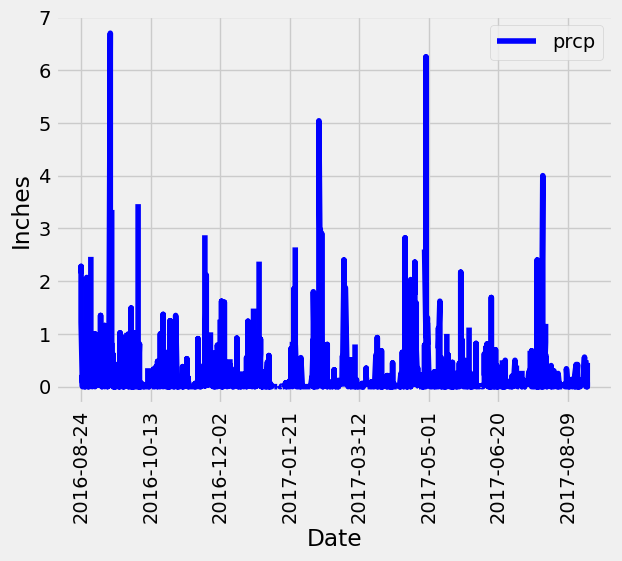

In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
from datetime import datetime, timedelta
start_date = datetime.strptime(recent_date.date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
last_year = start_date - timedelta(days=365)

print("Most Recent Date:", start_date) 
print("Past 12 Months:", last_year)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df= pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
prcp_df.sort_values(by='date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(prcp_df['date'], prcp_df['precipitation'], color='b', label='prcp')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(9))
plt.xticks(rotation=90)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='upper right')
plt.show()

In [33]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = prcp_df['precipitation'].describe()
summary_stats_df = summary_stats.reset_index()
summary_stats_df

,index,precipitation
0,count,2015.000000
1,mean,0.176462
2,std,0.460288
3,min,0.000000
4,25%,0.000000
5,50%,0.020000
6,75%,0.130000
7,max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(station.station)).all()

station_count

[(9,)]

In [ ]:
# Design a query to find the most active stations
# List the stations and their counts in descending order
active_stations = (
    session.query(
        measurement.station, 
        func.count(measurement.station)
    )
    .group_by(measurement.station)
    .order_by(func.count(measurement.station).desc())
    .all()
)


active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

temperature_stats = ( 
    session.query( 
        func.min(measurement.tobs).label('lowest_temp'), 
        func.max(measurement.tobs).label('highest_temp'), 
        func.avg(measurement.tobs).label('average_temp') 
    ) 
    .filter(measurement.station == most_active_station) 
    .all()
)

temperature_stats

[(54.0, 85.0, 71.66378066378067)]

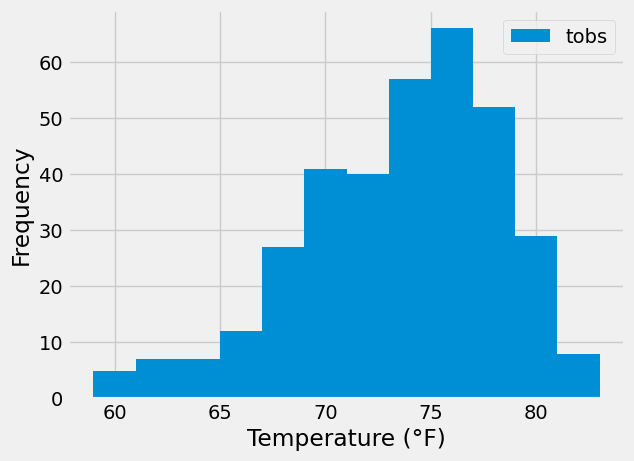

In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station = active_stations[0][0]
temperature_data = ( 
    session.query(measurement.date, measurement.tobs) 
    .filter(measurement.station == most_active_station) 
    .filter(measurement.date >= last_year) 
    .all()
)

# Extract the temperature observations 
temperatures = [temp.tobs for temp in temperature_data] 

#Plot the results as a histogram 
plt.hist(temperatures, bins=12, label='tobs') 
plt.xlabel('Temperature (°F)') 
plt.ylabel('Frequency') 
plt.grid(True)
plt.legend(loc='upper right')
plt.show()



# Close Session

In [30]:
# Close Session
session.close()